On commence par importer les bibliothèques qui vont être nécessaires.

In [41]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

In [42]:
!pip install ucimlrepo

In [43]:
from ucimlrepo import fetch_ucirepo #D'où on prend nos données

# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
# get features and target
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
data = pd.concat([X, y], axis=1)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [44]:
data.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,44923,45211,43354,45211,45211.000000,45211,45211,32191,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,8252,45211
unique,NaN,11,3,3,2,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,failure,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,4901,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


On peut commencer par voir qu'au niveau du 'count' (le nombre d'occurrences non vide), les nombres ne sont pas égaux entre les différentes colonnes, ce qui signifie qu'on va devoir réaliser un travail de nettoyage dessus, tout en estimant si l'on doit supprimer ou transformer la ligne ayant une 'donnée vide'.

Comme attendu, pour toutes les variables catégoriels (str) on ne peut pas calculer la moyenne, std ou autre.
On peut voir que le profil (à l'aide des features qui reviennent le +) type, est un ouvrier (blue collar) marié et ayant été en études secondaires (etc..) : il serait intéressant de vérifier si le dataset est bien équilibré pour ne pas avoir de biais dans l'analyse.

Les études sont classées en trois catégories.
On peut voir aussi des variables qui devraient sûrement nous être utiles : le fait d'avoir fait défaut déjà ou non, et le montant sur le compte bancaire (balance). De même, 'housing' et 'loan' devraient être pertinents.
Néanmoins, 'contact', 'day_of_the_week', 'month' paraissent peu pertinents pour le moment, même s'ils pourront mener à une analyse temporelle.

*duration* : Durée du dernier contact téléphonique avec le client (en secondes).

*campaign* : Nombre de contacts réalisés avec ce client lors de cette campagne marketing.

*pdays* : Nombre de jours écoulés depuis que le client a été contacté lors d’une campagne précédente.
avec pdays = -1 signifie jamais contacté auparavant.

*previous* : Nombre de contacts réalisés dans toutes les campagnes précédentes.

*poutcome* : Résultat de la dernière campagne marketing : "success", "failure" ou "nonexistent" → le client n’a jamais été contacté avant

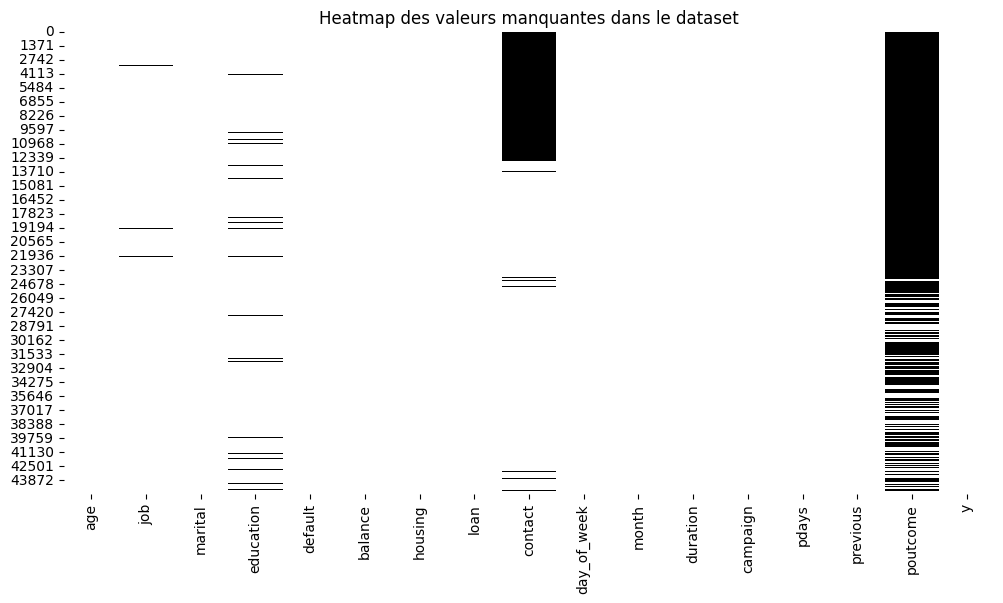

In [45]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), 
            cbar=False, 
            cmap='Greys')
plt.title("Heatmap des valeurs manquantes dans le dataset")
plt.show()


On voit que là où on manque le + de valeurs est dans *contact* où on semble manquer au moins 25% de valeurs et dans *poutcome* où il manque >95% de valeurs.

Pour *contact* cela ne devrait pas nous poser véritablement de problèmes car on peut faire l'hypothèse plutôt vraisemblable que le moyen de contacter n'a que très peu d'influences sur le résultat (on va vérifier ceci juste après).

Pour *poutcome* cela est assez étrange, peut-être que la variable est mal 'annotée', et met les clients qui n'ont jamais été contacté auparavant comme inexistant (malgré la présence de 3 catégories). Il va falloir regarder ceci de plus près.

Le dernier pour lequel il manque un peu de valeurs (mais pas substantiellement) est la variable *education* : on va regarder ce que cela représente en %.

In [46]:
#On fait le choix de remplacer toutes les valeurs manquantes des colonnes peu vides par la catégorie qui tombe le +
#C'est un choix arbitraire que l'on pourrait éventuellement rediscuter (par exemple dans les valeurs manquantes répartir selon la répartition de l'échantillon)
data['job'] = data['job'].fillna(data['job'].mode().iloc[0])
data['education'] = data['education'].fillna(data['education'].mode().iloc[0])
data['balance'] = data['balance'].fillna(data['balance'].mode().iloc[0])
data['marital'] = data['marital'].fillna(data['marital'].mode().iloc[0])
data['default'] = data['default'].fillna(data['default'].mode().iloc[0])
data['housing'] = data['housing'].fillna(data['housing'].mode().iloc[0])
data['loan'] = data['loan'].fillna(data['loan'].mode().iloc[0])

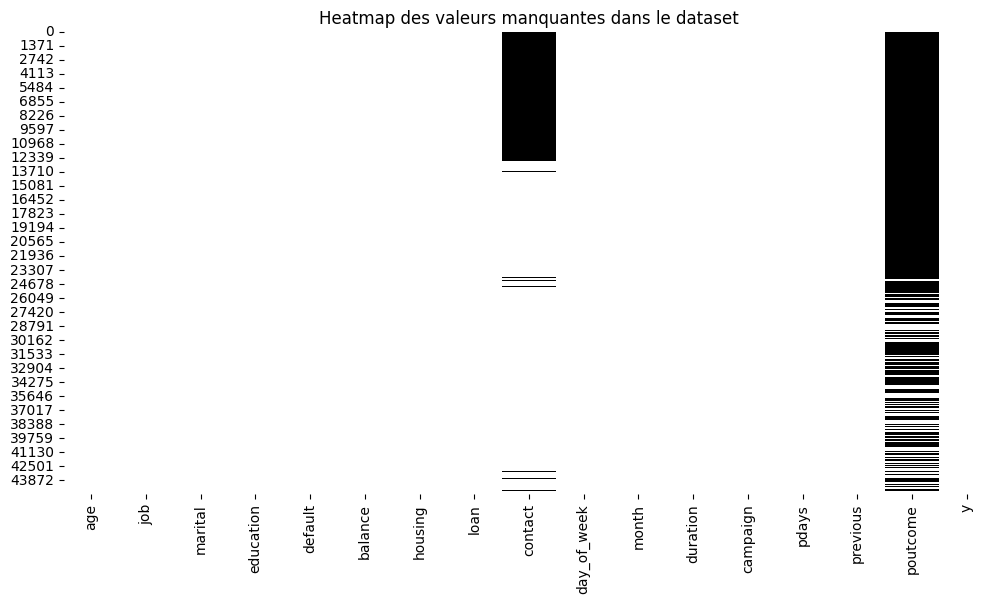

In [47]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), 
            cbar=False, 
            cmap='Greys')
plt.title("Heatmap des valeurs manquantes dans le dataset")
plt.show()


In [48]:
data['contact'].value_counts(normalize=True)

contact
cellular     0.909726
telephone    0.090274
Name: proportion, dtype: float64

<Figure size 800x500 with 0 Axes>

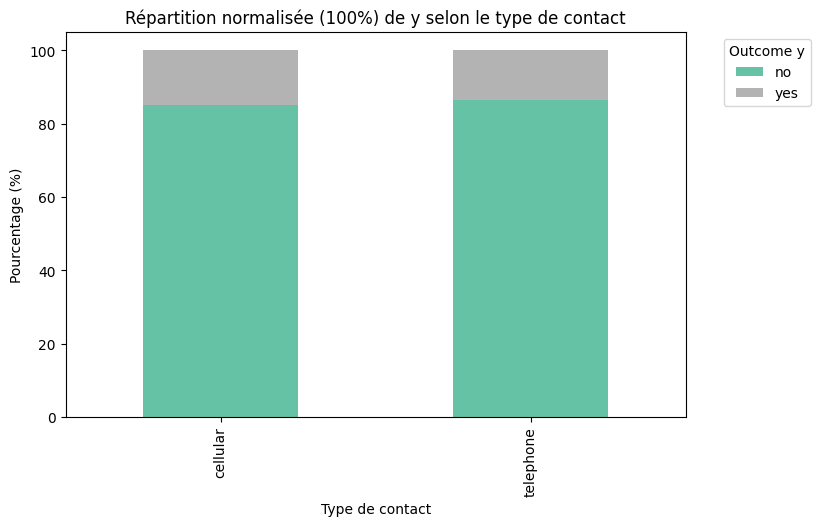

In [49]:
table = data.groupby(['contact','y']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1) 
#D'abord on compte combien de lien pour chaque possibilité
#Ensuite avec le unstack on fait la transposée de notre tableau', pour pouvoir afficher le graphique après
#Le .apply est juste ici pour normaliser les valeurs.
plt.figure(figsize=(8,5))
table.plot(kind='bar', stacked=True, colormap='Set2', figsize=(8,5)) #Afficher la répartition et non le comptage

plt.title("Répartition normalisée (100%) de y selon le type de contact")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Type de contact")
plt.legend(title="Outcome y", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

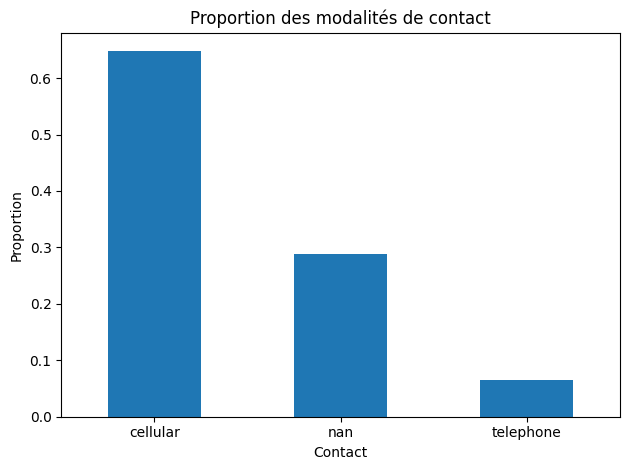

In [51]:
data['contact'].value_counts(normalize=True, dropna=False).plot(kind='bar')
plt.ylabel("Proportion")
plt.xlabel("Contact")
plt.title("Proportion des modalités de contact")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


On voit donc bien que malgré le déséquilibre total dans l'échantillon entre 'cellular' et 'telephone', la répartition de oui et de non semble la même entre cellular et telephone, ce qui nous donne un premier indice sur son apport au modèle.

In [52]:
import statsmodels.formula.api as smf

# Encoder y en numérique dans le dataframe (obligatoire pour la formule)
df = data.copy()
df['y'] = df['y'].replace({'yes': 1, 'no': 0}).astype(float) #sinon on peut pas faire de régression

# Régression OLS avec formule automatique, dans l'autre cas ça plantait
model = smf.ols(
    formula = "y ~ age + balance + day_of_week + duration + campaign + pdays + previous + contact + month + job + marital + education + default + housing + loan + poutcome",
    data = df
).fit()

print(model.summary())


/tmp/ipykernel_10613/2841003652.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0}).astype(float) #sinon on peut pas faire de régression


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     130.6
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:52:30   Log-Likelihood:                -2594.7
No. Observations:                8182   AIC:                             5267.
Df Residuals:                    8143   BIC:                             5541.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

Ceci nous permet de voir qu'en isolant l'effet de toutes les autres variables : même s'il semblait que la proportion cellular/telephone parmi les y=yes or no était presque la même, dans les faits, au seuil de 5% on peut rejeter l'hypothèse que le coefficient lié à la variable *contact* soit nul (donc sans effet sur y), autrement dit : ce coefficient est significatif (au seuil de 5%).
On devra donc trouver un autre moyen de palier l'absence de réponses.

Néanmoins, même s'il est significatif en lui même (lorsqu'il n'est pas vide et apporte une valeur), l'absence de valeur peut ne pas être significative (avoir une valeur manquante pourrait alors n'être que le résultat d'une mauvaise formatation des données et donc on pourrait venir tenter de prédire ces valeurs manquantes plutôt que leur imputer une valeur 'Manquante' qui créerait un biais dans le modèle)

On va donc tenter de faire un test de significativité de la valeur manquante : pour cela : on va créer un nouveau feature qui affiche 'True' s'il y a une valeur manquante et 'False' sinon, on va ensuite réaliser une régression à l'aide des features (utilisées dans la régression précédente) pour essayer de prédire 'True' or 'False'. Ensuite, on va venir regarder si une loi de Bernouilli (paramètre 1/4, la fréquence empirique de valeur manquante) va nous permettre de prédire de manière significativement moins bien que notre prédiction à l'aide des features : si c'est le cas, alors ça veut dire qu'il y a un sens à ces valeurs manquantes, qu'il y a une 'raison statistiques' qui explique cela. 
Pour le cas de poutcome, la question sera plus difficile, puisqu'il faudra juger sur quelles variables est il pertinent de réaliser ce test de significativité : sur les features qui aurait effectivement pu prédire le True/False (Valeur manquante ou non) ou sur toutes les features qui pourraient indiquer une raison plus propre au jeu de données qu'aux individus concernés. Cette question est à creuser.

In [53]:
data['contact_missing'] = data['contact'].isna()

In [54]:

# Encoder y en numérique dans le dataframe (obligatoire pour la formule)
df2 = data.copy()
df2['contact_missing'] = df2['contact_missing'].replace({'True': 1, 'False': 0}).astype(float) #sinon on peut pas faire de régression

# Régression OLS avec formule automatique, dans l'autre cas ça plantait
model = smf.ols(
    formula = "contact_missing ~ age + balance + day_of_week + duration + campaign + pdays + previous + month + job + marital + education + default + housing + loan +y",
    data = df2
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        contact_missing   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     1753.
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:52:32   Log-Likelihood:                -8573.4
No. Observations:               45211   AIC:                         1.722e+04
Df Residuals:                   45174   BIC:                         1.754e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

On a un R^2 plutôt élevé (58%), mais il est intéressant de noter que si on enlève month on obtient un R^2 nettement plus faible (12%). Et qu'à lui seul, le feature 'month' permet d'avoir un R^2 à 50% environ. En particulier, on remarque que les t-value de juin et de mai sont > à 90, ce qui montre (on peut calculer pour en avoir le coeur nette) une évidente significativité statistique (July et October semble aussi significatifs au seuil de 1%).

In [55]:
# Encoder y en numérique dans le dataframe (obligatoire pour la formule)
df2 = data.copy()
df2['contact_missing'] = df2['contact_missing'].replace({'True': 1, 'False': 0}).astype(float) #sinon on peut pas faire de régression

# Régression OLS avec formule automatique, dans l'autre cas ça plantait
model = smf.ols(
    formula = "contact_missing ~ month",
    data = df2
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        contact_missing   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     4291.
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:52:32   Log-Likelihood:                -12169.
No. Observations:               45211   AIC:                         2.436e+04
Df Residuals:                   45199   BIC:                         2.447e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0020      0.006      0.350   

Puisqu'on voit ici que quelques mois, disparates et sans points communs a priori, affectent le fait d'avoir une valeur manquante ou non, on peut en conclure que c'est une mauvaise formation du jeu de donée et qu'en elle-même, être une valeur manquante n'apporte pas d'information, autre que celle d'avoir été dans ce mois

On confirme ceci avec un petit graphique qui vient nous confirmer ce qu'on voulait voir.

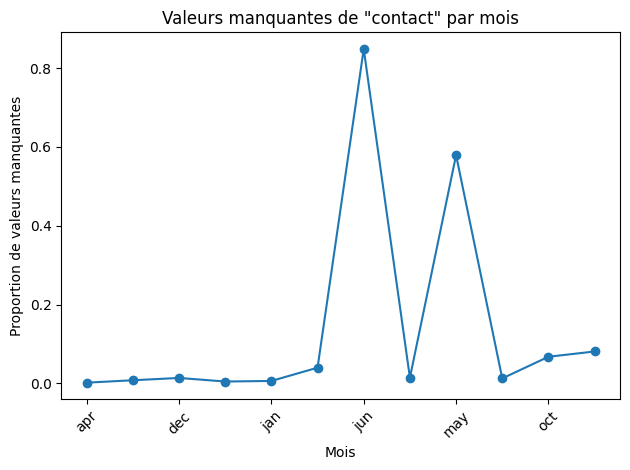

In [56]:
missing_by_month = (
    data
    .groupby('month')['contact_missing']
    .mean()
)

import matplotlib.pyplot as plt

plt.figure()
missing_by_month.plot(kind='line', marker='o')
plt.ylabel('Proportion de valeurs manquantes')
plt.xlabel('Mois')
plt.title('Valeurs manquantes de "contact" par mois')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


La comparaison des modèles montre que les effets temporels expliquent l’essentiel du mécanisme de valeurs manquantes (R² ≈ 0,51). L’ajout des caractéristiques individuelles améliore marginalement le pouvoir explicatif (R² ≈ 0,58), suggérant que le missingness est principalement gouverné par des facteurs de collecte, avec une composante individuelle secondaire.

On peut donc venir imputer des valeurs à contact (cellular/telephone) à l'aide d'un XGBoost sur les valeurs non manquantes, et ainsi remplacer les valeurs manquantes par notre imputation : on va néanmoins garder la variable contact_missing en variable de contrôle, et on va toujours garder la temporalité en tête.

In [57]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

df3= data.copy()

# 1. Define wanted features WITHOUT 'contact'
wanted = [
    "age","balance","day_of_week","duration","campaign","pdays","previous",
    "month","job","marital","education","default","housing","loan",
    "poutcome"
]

features = [c for c in df3.columns if c in wanted]

# 2. Split train / pred
df_train = df3.dropna(subset=['contact']).copy()
df_pred  = df3[df3['contact'].isna()].copy()

# 3. Encode target BEFORE any factorization
le = LabelEncoder()
df_train['contact_num'] = le.fit_transform(df_train['contact'])

# 4. Factorize ONLY the feature columns (never the target, never 'contact')
cat_cols = df_train[features].select_dtypes(include=['object','category']).columns

for c in cat_cols:
    df_train[c], uniques = pd.factorize(df_train[c])
    df_pred[c] = df_pred[c].map({u:i for i,u in enumerate(uniques)}).fillna(-1).astype(int)

# 5. XGBoost
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(df_train[features], df_train['contact_num'])

# 6. Predict missing contact
pred_num = model.predict(df_pred[features])
pred_label = le.inverse_transform(pred_num)

df_pred['contact_pred'] = pred_label

# 7. Keep original contact when known
df_train['contact_pred'] = df_train['contact']

# 8. Merge
df_final = pd.concat([df_train, df_pred]).sort_index()


In [58]:
data['contact']=df_final['contact_pred']

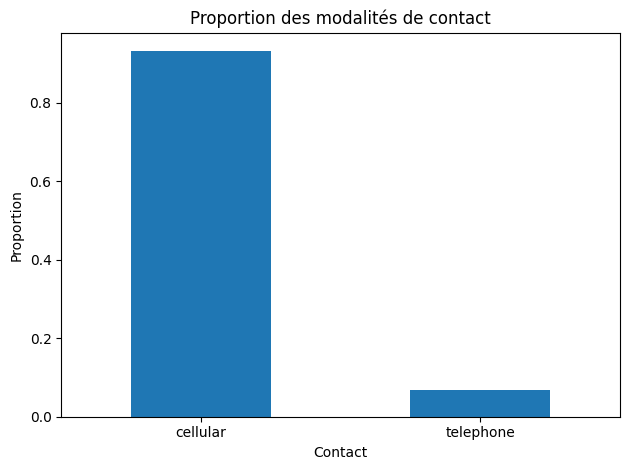

In [59]:
data['contact'].value_counts(normalize=True, dropna=False).plot(kind='bar')
plt.ylabel("Proportion")
plt.xlabel("Contact")
plt.title("Proportion des modalités de contact")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
